In [5]:
directory = '/Users/davidkarapetyan/Documents/workspace/data_analysis/'
csv_file = 'data/park345_FL17_SW_air.csv'

import pandas as pd
# for wide terminal display of pandas dataframes
pd.options.display.width = 120
pd.options.display.max_rows = 10000
import numpy as np
import statsmodels.tsa.arima_model as arima
import statsmodels.tsa.statespace.sarimax as sarimax

# plot inline
%pylab inline
# IPython.get_ipython().magic('matplotlib inline')
import matplotlib.pylab as pylab

pylab.rcParams['figure.figsize'] = 14, 6


# load dataframe, and subset out relevant columns
park_data = pd.read_csv(directory + csv_file, error_bad_lines=False)
park_data.columns = ['ID', 'TIMESTAMP',
'TRENDFLAGS', 'STATUS',
'VALUE', 'TRENDFLAGS_TAG',
'STATUS_TAG']
park_data = park_data.sort('TIMESTAMP')


# construct time series, getting rid of microseconds
park_ts = pd.Series(list(park_data.VALUE),
pd.DatetimeIndex(park_data.TIMESTAMP),
name="steam values")

park_ts = park_ts.loc[park_ts != 0].resample('15Min ').interpolate()
print(park_ts)

Populating the interactive namespace from numpy and matplotlib
2013-03-20 02:15:00     66.976562
2013-03-20 02:30:00     66.613251
2013-03-20 02:45:00     66.717041
2013-03-20 03:00:00     66.561340
2013-03-20 03:15:00     66.509460
2013-03-20 03:30:00     66.509460
2013-03-20 03:45:00     66.301880
2013-03-20 04:00:00     66.224030
2013-03-20 04:15:00     66.224030
2013-03-20 04:30:00     65.912659
2013-03-20 04:45:00     65.964569
2013-03-20 05:00:00     65.808868
2013-03-20 05:15:00     65.601257
2013-03-20 05:30:00     65.653168
2013-03-20 05:45:00     67.677155
2013-03-20 06:00:00     69.623291
2013-03-20 06:15:00     69.571411
2013-03-20 06:30:00     69.415710
2013-03-20 06:45:00     70.323914
2013-03-20 07:00:00     70.479614
2013-03-20 07:15:00     70.894806
2013-03-20 07:30:00     72.088440
2013-03-20 07:45:00     72.763123
2013-03-20 08:00:00     73.178284
2013-03-20 08:15:00     73.411804
2013-03-20 08:30:00     73.723175
2013-03-20 08:45:00     73.126373
2013-03-20 09:00:00

In [6]:
print(arima.ARIMA(park_ts, (0, 1, 0)).fit().summary())

/Users/davidkarapetyan/anaconda/lib/python3.4/site-packages/statsmodels/base/model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


IndexError: list index out of range

We see that ARIMA is not currently fitting the time series data. We look for
an appropriate transformation of the time series to improve our ARIMA fitting.

###Log Ratio Transformation

To get a properly scaled plot, we filter out the outlier values occuring at
the end of day (shift from some steam usage to none at all as systems
restart, and spikes from ramp-up time at the beginning of the day).

count    34966.000000
mean         0.000038
std          0.008508
min         -0.117525
5%          -0.004291
50%          0.000000
95%          0.003898
max          1.226083
Name: steam values, dtype: float64


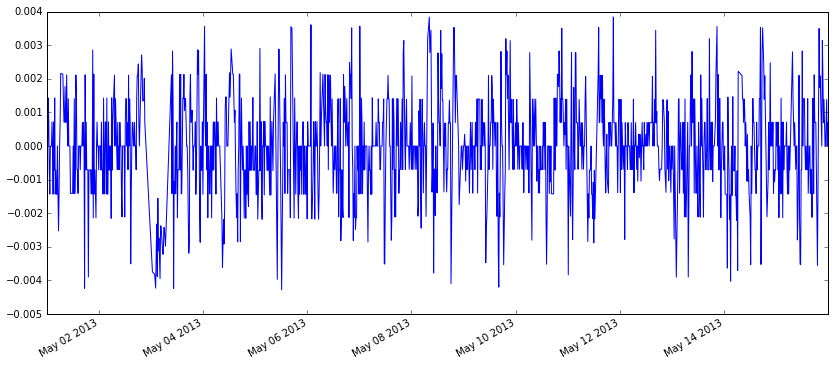

In [7]:
park_ts_logr = (np.log(park_ts / park_ts.shift(1)))[1:]
basic_stats = park_ts_logr.describe(percentiles=[0.05, 0.95])

print(basic_stats)
park_ts_logr[park_ts_logr.between(basic_stats['5%'], 
              basic_stats['95%']
             )]['2013-05-01': '2013-05-15'].plot()

The seasonality is clear. We now plot a single day, filtering out
outliers to get a properly scaled figure.

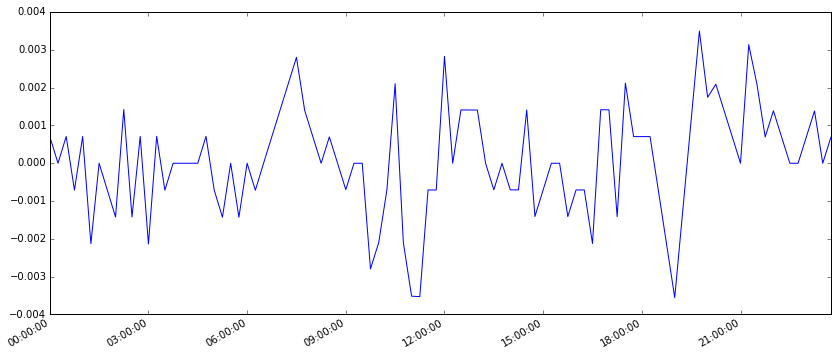

In [8]:
park_ts_logr[park_ts_logr.between(basic_stats['5%'], 
              basic_stats['95%']
             )]['2013-05-15'].plot()

Next, we utilise a SARIMAX model, with seasonality at 96
(our data points are spaced at 15 minute intervals),
and analyze a week's worth of data (starting on Monday, and ending on Friday).

In [9]:
print(sarimax.SARIMAX(park_ts_logr.loc['2013-05-06':'2013-05-10'],
seasonal_order=(0, 1, 0, 96)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                  480
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 96)   Log Likelihood                1663.348
Date:                            Thu, 24 Sep 2015   AIC                          -3322.697
Time:                                    13:29:23   BIC                          -3314.349
Sample:                                05-06-2013   HQIC                         -3319.415
                                     - 05-10-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0807      0.033      2.475      0.013       0.017       0.145
sigma2      1.009e-05   2.84e-07   

While the fit isn't terrible, it perhaps can be improved by first observing
that we have spikes in our at the beginning of the day. This is due to
the ratio of consecutive values dipping suddenly at the end of day
as systems are ramped down.
Observe that the only negative values in the data occur at the start of
day. We filter these out, and re-run SARIMA.

In [10]:
print(sarimax.SARIMAX(
park_ts_logr[park_ts_logr > 0]['2013-05-06':'2013-05-10'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                  189
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                 420.252
Date:                            Thu, 24 Sep 2015   AIC                           -836.504
Time:                                    13:29:27   BIC                           -830.020
Sample:                                05-06-2013   HQIC                          -833.877
                                     - 05-10-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2892      0.109      2.657      0.008       0.076       0.503
sigma2       7.64e-06   4.94e-07   

Our data is clustered very close to the mean--i.e, the spikes are very small spikes. Consequently, the positive of filtering them out (i.e. smoothing the data) outweighs the drawback of reducing the number of points to fit. 

Now, let's use a larger input
(beginning on a Monday, and ending on a Friday), and fit another
Sarimax model to our beginning-of-day spike-filtered data.

In [ ]:
bobo = sarimax.SARIMAX(
park_ts_logr[park_ts_logr > 0]['2013-05-06':'2013-06-07'],
seasonal_order=(0, 1, 0, 95)).fit()

AttributeError: 'SARIMAXResults' object has no attribute 'plot_predict'

As expected, this is an even better fit than the fit for the week's worth of data.
Lastly, we input three # months worth of data, beginning on a Monday,
and ending on a Friday.

In [12]:
print(sarimax.SARIMAX(park_ts_logr[park_ts_logr > 0]['2013-05-06': '2013-08-08'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 3910
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood               17012.731
Date:                            Thu, 24 Sep 2015   AIC                         -34021.463
Time:                                    13:29:47   BIC                         -34008.920
Sample:                                05-06-2013   HQIC                        -34017.012
                                     - 08-08-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1952      0.014     14.246      0.000       0.168       0.222
sigma2      7.833e-06   6.29e-08   

Let's contrast this with our fit when we include the end-of-day spikes:

In [13]:
bobo = sarimax.SARIMAX(park_ts_logr['2013-05-06': '2013-08-08'],
seasonal_order=(0, 1, 0, 96)).fit()

Hence, it makes sense to keep the analysis of
15-minute ramp-up and ramp-down times together with the analysis of the remaining data.

##SARIMAX on Data for Individual Days

We next investigate seasonality on a weekly basis. That is, we
isolate the 5-day workweek into 5 chunks, and run SARIMAX on
each chunk separately.

In [14]:
print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 1,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 2,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 3,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 4,
park_ts_logr > 0)],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 1823
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                6490.371
Date:                            Thu, 24 Sep 2015   AIC                         -12976.742
Time:                                    13:30:16   BIC                         -12965.725
Sample:                                03-25-2013   HQIC                        -12972.678
                                     - 02-17-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4334      0.015     28.559      0.000       0.404       0.463
sigma2      3.199e-05   1.99e-07   

Including the spikes gives:

In [15]:
print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 0],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 1],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 2],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 3],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 4],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 4992
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood               18704.743
Date:                            Thu, 24 Sep 2015   AIC                         -37405.486
Time:                                    13:31:05   BIC                         -37392.455
Sample:                                03-25-2013   HQIC                        -37400.918
                                     - 03-17-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2280      0.004     53.460      0.000       0.220       0.236
sigma2      2.818e-05   1.06e-07   

##ARIMAX For Ramp-up and Ramp-Down

We shall treat Monday ramp-ups separately from the remaining days of the week,
due to difference between system-idling over weekends and weekdays.

In [16]:
print(arima.ARIMA(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr < 0)],
order=(0, 1, 0)).fit().summary())

IndexError: list index out of range

Observe that between end of day and start of day, chilled water temperature
decreases, and so $$\frac{T_k(0 + 00:15)}{T_k(0)} = a_k < 1$$ for each
entry in our training set. The set $\{a_k\}_k$ will hopefully consist of
entries that are clustered near one another, with some reasonable volatility.
Taking a logarithm of them will result in an exponential increase in
volatility, since $log(x)$ is an exponential function of $x$ for decreasing
$x < 1$. This will result in decreasing the goodness-of-fit of a linear
model, from a least-squares standpoint. Consequently, we exponentiate our
time series data, and re-fit:

In [ ]:
print(arima.ARIMA(np.exp(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr < 0)]),
order=(0, 1, 0)).fit().summary())

Observe that the fit has improved, though not dramatically like for some of our other time series. This is due to Monday ramp-up values being very close to the mean. In general, our time series values are clustered very close together throughout the week. 